In [514]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# **Load Data**

In [515]:
df = pd.read_csv(r'stock_data/Tata_Motor_Stock.csv',parse_dates=[0],header=[0])

In [516]:
df.head()

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,2024-09-18,EQ,978.2,983.7,957.15,974.95,959.2,962.05,968.76,"1,179.00",608.3,"1,20,44,431","11,66,81,31,471.45","2,41,634"
1,2024-09-17,EQ,995,995,960,988.4,975,974.95,969.17,"1,179.00",608.3,"4,45,16,613","43,14,40,98,335.60","5,18,729"
2,2024-09-16,EQ,997,999.9,984.5,992.1,988.45,988.4,990.38,"1,179.00",608.3,"58,36,274","5,78,01,10,599.55","1,89,546"
3,2024-09-13,EQ,994.9,"1,006.00",988,986.15,991.85,992.1,994.82,"1,179.00",608.3,"1,32,03,676","13,13,53,30,656.10","3,30,078"
4,2024-09-12,EQ,976.3,988,958,976.3,984,986.15,973.48,"1,179.00",608.3,"2,56,75,836","24,99,48,36,924.25","6,12,687"


In [517]:
df.columns = df.columns.str.lower().str.replace(' ','')
df.columns = df.columns.str.replace('.','_')

In [518]:
df.dtypes

date          datetime64[ns]
series                object
open                  object
high                  object
low                   object
prev_close            object
ltp                   object
close                 object
vwap                  object
52wh                  object
52wl                 float64
volume                object
value                 object
nooftrades            object
dtype: object

In [519]:
df.columns[2:]

Index(['open', 'high', 'low', 'prev_close', 'ltp', 'close', 'vwap', '52wh',
       '52wl', 'volume', 'value', 'nooftrades'],
      dtype='object')

In [520]:
float_columns = ['open', 'high', 'low', 'prev_close', 'ltp', 'close', 'vwap', '52wh',
        'volume', 'value', 'nooftrades']
float_columns

['open',
 'high',
 'low',
 'prev_close',
 'ltp',
 'close',
 'vwap',
 '52wh',
 'volume',
 'value',
 'nooftrades']

In [521]:
def convert_to_num(value):
    if ',' in value:
        value = value.replace(',','')
    else:
        pass
    return value


In [522]:
for col in float_columns:
    df[col] = df[col].apply(convert_to_num)

In [523]:
for col in float_columns:
    df[col] = df[col].astype('float')

In [524]:
df.dtypes

date          datetime64[ns]
series                object
open                 float64
high                 float64
low                  float64
prev_close           float64
ltp                  float64
close                float64
vwap                 float64
52wh                 float64
52wl                 float64
volume               float64
value                float64
nooftrades           float64
dtype: object

In [525]:
df.shape

(1185, 14)

In [526]:
df.head()

,date,series,open,high,low,prev_close,ltp,close,vwap,52wh,52wl,volume,value,nooftrades
0,2024-09-18,EQ,978.2,983.7,957.15,974.95,959.20,962.05,968.76,1179.0,608.3,12044431.0,1.166813e+10,241634.0
1,2024-09-17,EQ,995.0,995.0,960.00,988.40,975.00,974.95,969.17,1179.0,608.3,44516613.0,4.314410e+10,518729.0
2,2024-09-16,EQ,997.0,999.9,984.50,992.10,988.45,988.40,990.38,1179.0,608.3,5836274.0,5.780111e+09,189546.0
3,2024-09-13,EQ,994.9,1006.0,988.00,986.15,991.85,992.10,994.82,1179.0,608.3,13203676.0,1.313533e+10,330078.0
4,2024-09-12,EQ,976.3,988.0,958.00,976.30,984.00,986.15,973.48,1179.0,608.3,25675836.0,2.499484e+10,612687.0


In [527]:
df.sort_values('date', ascending=True, inplace=True)

In [528]:
df.set_index('date',inplace=True)

In [529]:
df.head()

,series,open,high,low,prev_close,ltp,close,vwap,52wh,52wl,volume,value,nooftrades
date,,,,,,,,,,,,,
2020-01-01,EQ,185.15,186.70,183.60,185.15,184.25,184.45,185.11,239.35,106.0,25968357.0,4.806946e+09,99072.0
2020-01-02,EQ,185.00,194.70,184.60,184.45,193.85,193.75,190.57,239.35,106.0,57289863.0,1.091755e+10,251258.0
2020-01-03,EQ,192.90,195.65,189.25,193.75,191.25,191.10,192.00,239.35,106.0,47572728.0,9.134140e+09,185614.0
2020-01-06,EQ,191.00,191.00,185.05,191.10,185.40,185.65,187.30,239.35,106.0,28621212.0,5.360801e+09,138113.0
2020-01-07,EQ,187.00,189.40,182.30,185.65,184.35,184.70,185.41,239.35,106.0,34995035.0,6.488309e+09,133404.0


In [530]:
px.line(df['vwap']) #d=1

In [531]:
df.isna().sum()

series        0
open          0
high          0
low           0
prev_close    0
ltp           0
close         0
vwap          0
52wh          0
52wl          0
volume        0
value         0
nooftrades    0
dtype: int64

In [532]:
df.head()

,series,open,high,low,prev_close,ltp,close,vwap,52wh,52wl,volume,value,nooftrades
date,,,,,,,,,,,,,
2020-01-01,EQ,185.15,186.70,183.60,185.15,184.25,184.45,185.11,239.35,106.0,25968357.0,4.806946e+09,99072.0
2020-01-02,EQ,185.00,194.70,184.60,184.45,193.85,193.75,190.57,239.35,106.0,57289863.0,1.091755e+10,251258.0
2020-01-03,EQ,192.90,195.65,189.25,193.75,191.25,191.10,192.00,239.35,106.0,47572728.0,9.134140e+09,185614.0
2020-01-06,EQ,191.00,191.00,185.05,191.10,185.40,185.65,187.30,239.35,106.0,28621212.0,5.360801e+09,138113.0
2020-01-07,EQ,187.00,189.40,182.30,185.65,184.35,184.70,185.41,239.35,106.0,34995035.0,6.488309e+09,133404.0


In [533]:
df.columns

Index(['series', 'open', 'high', 'low', 'prev_close', 'ltp', 'close', 'vwap',
       '52wh', '52wl', 'volume', 'value', 'nooftrades'],
      dtype='object')

**Calculating moving average**

In [534]:
lag_features = ['high','low','volume','nooftrades',]
window_1= 3
window_2 = 7

In [535]:
for feature in lag_features:
    df[feature+'_mean_rolling_3'] = df[feature].rolling(window=window_1).mean()
    df[feature+'_mean_rolling_7'] = df[feature].rolling(window=window_2).mean()

In [536]:
for feature in lag_features:
    df[feature+'_std_rolling_3'] = df[feature].rolling(window=window_1).std()
    df[feature+'_std_rolling_7'] = df[feature].rolling(window=window_2).std()

In [537]:
df.head(20)

,series,open,high,low,prev_close,ltp,close,vwap,52wh,52wl,...,nooftrades_mean_rolling_3,nooftrades_mean_rolling_7,high_std_rolling_3,high_std_rolling_7,low_std_rolling_3,low_std_rolling_7,volume_std_rolling_3,volume_std_rolling_7,nooftrades_std_rolling_3,nooftrades_std_rolling_7
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,EQ,185.15,186.70,183.60,185.15,184.25,184.45,185.11,239.35,106.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,EQ,185.00,194.70,184.60,184.45,193.85,193.75,190.57,239.35,106.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,EQ,192.90,195.65,189.25,193.75,191.25,191.10,192.00,239.35,106.0,...,178648.000000,NaN,4.916045,NaN,3.015101,NaN,1.603230e+07,NaN,76331.766100,NaN
2020-01-06,EQ,191.00,191.00,185.05,191.10,185.40,185.65,187.30,239.35,106.0,...,191661.666667,NaN,2.456793,NaN,2.564664,NaN,1.458009e+07,NaN,56814.421236,NaN
2020-01-07,EQ,187.00,189.40,182.30,185.65,184.35,184.70,185.41,239.35,106.0,...,152377.000000,NaN,3.246665,NaN,3.500119,NaN,9.643512e+06,NaN,28880.223285,NaN
2020-01-08,EQ,180.20,184.20,180.20,184.70,182.75,182.55,182.39,239.35,106.0,...,122703.000000,NaN,3.555278,NaN,2.432249,NaN,6.567109e+06,NaN,22735.037079,NaN
2020-01-09,EQ,184.85,192.75,184.25,182.55,192.40,192.00,189.24,239.35,106.0,...,133115.000000,153343.142857,4.308229,4.177305,2.025463,2.779517,9.703376e+06,1.266541e+07,36379.360948,54283.961359
2020-01-10,EQ,192.00,199.00,190.00,192.00,194.25,196.35,193.86,239.35,106.0,...,166566.333333,172584.000000,7.429726,4.791200,4.924514,3.513240,1.919538e+07,1.432957e+07,68625.325605,55692.921426
2020-01-13,EQ,194.75,197.75,191.40,196.35,195.90,196.25,194.56,239.35,106.0,...,185643.666667,158664.857143,3.307189,5.161141,3.789129,4.222728,1.130692e+07,1.256864e+07,42385.117793,43620.237163


In [538]:
df.isna().sum()

series                       0
open                         0
high                         0
low                          0
prev_close                   0
ltp                          0
close                        0
vwap                         0
52wh                         0
52wl                         0
volume                       0
value                        0
nooftrades                   0
high_mean_rolling_3          2
high_mean_rolling_7          6
low_mean_rolling_3           2
low_mean_rolling_7           6
volume_mean_rolling_3        2
volume_mean_rolling_7        6
nooftrades_mean_rolling_3    2
nooftrades_mean_rolling_7    6
high_std_rolling_3           2
high_std_rolling_7           6
low_std_rolling_3            2
low_std_rolling_7            6
volume_std_rolling_3         2
volume_std_rolling_7         6
nooftrades_std_rolling_3     2
nooftrades_std_rolling_7     6
dtype: int64

In [539]:
df.dropna(inplace=True)

In [540]:
df.columns

Index(['series', 'open', 'high', 'low', 'prev_close', 'ltp', 'close', 'vwap',
       '52wh', '52wl', 'volume', 'value', 'nooftrades', 'high_mean_rolling_3',
       'high_mean_rolling_7', 'low_mean_rolling_3', 'low_mean_rolling_7',
       'volume_mean_rolling_3', 'volume_mean_rolling_7',
       'nooftrades_mean_rolling_3', 'nooftrades_mean_rolling_7',
       'high_std_rolling_3', 'high_std_rolling_7', 'low_std_rolling_3',
       'low_std_rolling_7', 'volume_std_rolling_3', 'volume_std_rolling_7',
       'nooftrades_std_rolling_3', 'nooftrades_std_rolling_7'],
      dtype='object')

In [541]:
df.shape

(1179, 29)

In [542]:
ind_features = ['high_mean_rolling_3',
       'high_mean_rolling_7', 'low_mean_rolling_3', 'low_mean_rolling_7',
       'volume_mean_rolling_3', 'volume_mean_rolling_7',
       'nooftrades_mean_rolling_3', 'nooftrades_mean_rolling_7',
       'high_std_rolling_3', 'high_std_rolling_7', 'low_std_rolling_3',
       'low_std_rolling_7', 'volume_std_rolling_3', 'volume_std_rolling_7',
       'nooftrades_std_rolling_3', 'nooftrades_std_rolling_7']

In [543]:
train = df[:1000]
test = df[1000:]

In [544]:
train

,series,open,high,low,prev_close,ltp,close,vwap,52wh,52wl,...,nooftrades_mean_rolling_3,nooftrades_mean_rolling_7,high_std_rolling_3,high_std_rolling_7,low_std_rolling_3,low_std_rolling_7,volume_std_rolling_3,volume_std_rolling_7,nooftrades_std_rolling_3,nooftrades_std_rolling_7
date,,,,,,,,,,,,,,,,,,,,,
2020-01-09,EQ,184.85,192.75,184.25,182.55,192.40,192.00,189.24,239.35,106.0,...,133115.000000,153343.142857,4.308229,4.177305,2.025463,2.779517,9.703376e+06,1.266541e+07,36379.360948,54283.961359
2020-01-10,EQ,192.00,199.00,190.00,192.00,194.25,196.35,193.86,239.35,106.0,...,166566.333333,172584.000000,7.429726,4.791200,4.924514,3.513240,1.919538e+07,1.432957e+07,68625.325605,55692.921426
2020-01-13,EQ,194.75,197.75,191.40,196.35,195.90,196.25,194.56,239.35,106.0,...,185643.666667,158664.857143,3.307189,5.161141,3.789129,4.222728,1.130692e+07,1.256864e+07,42385.117793,43620.237163
2020-01-14,EQ,195.70,198.25,193.60,196.25,195.20,195.85,196.42,239.35,106.0,...,169604.333333,149467.285714,0.629153,5.482201,1.814754,5.015369,1.541529e+07,1.239129e+07,57899.444059,43778.268314
2020-01-15,EQ,195.00,201.70,194.00,195.85,199.70,200.35,198.74,239.35,106.0,...,146619.333333,153280.142857,2.150775,6.212008,1.400000,5.631808,5.661196e+06,1.186858e+07,22661.866921,43786.831793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,EQ,716.80,731.00,712.00,708.85,725.00,724.70,724.50,734.75,375.2,...,235075.333333,202622.571429,11.647747,8.182960,7.899420,11.888290,2.408773e+06,2.985667e+06,46397.756436,46225.348518
2023-12-26,EQ,727.40,727.50,716.60,724.70,720.00,719.55,721.73,734.75,375.2,...,230686.666667,208323.142857,10.168743,8.012958,10.671965,11.812141,2.664341e+06,2.953678e+06,50594.255527,41679.564415
2023-12-27,EQ,728.00,741.85,725.15,719.55,740.30,740.90,735.95,741.85,375.2,...,257577.000000,217999.285714,7.482145,9.243370,6.673143,12.253551,3.947824e+06,3.723607e+06,53861.589310,51749.433915


# **Apply Auto ARIMA Model**

In [546]:
# Define the model with auto_arima
model = auto_arima(y=train['vwap'], 
                   exogenous=train[ind_features],  # External predictors (independent features)
                   trace=True,                     # Print the output during model selection process
                   seasonal=False,                 # If data has seasonality, you can change this to True
                   stepwise=True)   

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6939.738, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6966.265, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6937.416, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6935.107, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6969.964, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6936.991, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6936.954, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6938.794, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6937.378, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.466 seconds


In [547]:
# Fit the model to the data
model.fit(train['vwap'], exogenous=train[ind_features])

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [548]:
# Make predictions
predictions = model.predict(n_periods=len(test), exogenous=test[ind_features])

In [549]:
predictions = np.array(predictions)

In [550]:
test['forcast'] = predictions

In [551]:
test

,series,open,high,low,prev_close,ltp,close,vwap,52wh,52wl,...,nooftrades_mean_rolling_7,high_std_rolling_3,high_std_rolling_7,low_std_rolling_3,low_std_rolling_7,volume_std_rolling_3,volume_std_rolling_7,nooftrades_std_rolling_3,nooftrades_std_rolling_7,forcast
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,EQ,785.00,798.7,781.05,779.95,792.00,790.60,791.96,802.9,381.0,...,299709.428571,24.828428,35.474624,21.288514,28.582479,1.588071e+07,1.160772e+07,192129.777386,134915.935084,792.631481
2024-01-02,EQ,800.50,804.0,779.00,790.60,786.00,784.40,787.89,804.0,381.0,...,311787.000000,2.797022,34.712292,15.060461,28.437354,1.617114e+07,1.111634e+07,177126.858034,128994.888043,793.235623
2024-01-03,EQ,786.05,790.0,776.25,784.40,782.60,781.45,782.06,804.0,381.0,...,304183.428571,7.068475,31.757794,2.408492,26.769225,2.737299e+06,1.143338e+07,30140.436908,132116.880724,793.839765
2024-01-04,EQ,798.00,801.8,791.30,781.45,795.70,795.75,796.06,804.0,381.0,...,320772.571429,7.528612,25.064163,8.014102,24.638008,3.177317e+06,1.080569e+07,39607.725926,123165.826463,794.443907
2024-01-05,EQ,799.00,805.9,787.10,795.75,792.00,790.95,795.04,805.9,381.0,...,317720.714286,8.254898,16.920616,7.766005,18.961182,2.876302e+06,1.103769e+07,38205.332106,124352.003022,795.048049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-12,EQ,976.30,988.0,958.00,976.30,984.00,986.15,973.48,1179.0,608.3,...,407167.285714,30.762816,37.309204,39.572939,44.047980,1.480537e+07,1.207591e+07,403620.066380,324378.384034,897.752194
2024-09-13,EQ,994.90,1006.0,988.00,986.15,991.85,992.10,994.82,1179.0,608.3,...,434319.714286,12.311275,36.509105,15.033989,39.990237,1.148300e+07,1.140140e+07,368219.901296,305706.153167,898.356336
2024-09-16,EQ,997.00,999.9,984.50,992.10,988.45,988.40,990.38,1179.0,608.3,...,429318.285714,9.154416,31.722307,16.403760,32.508704,1.002864e+07,1.164306e+07,215509.240245,309966.602465,898.960478


<Axes: xlabel='date'>

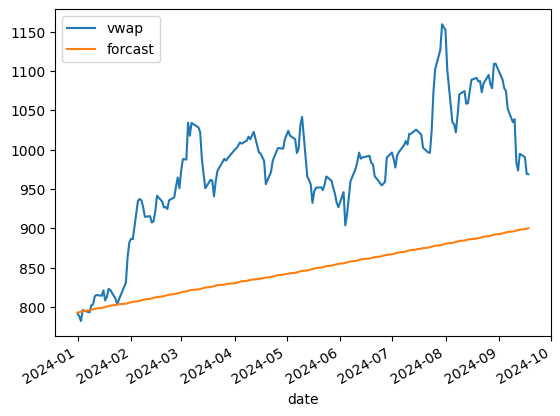

In [552]:
test[['vwap','forcast']].plot()

# **Apply ARIMA Model**

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

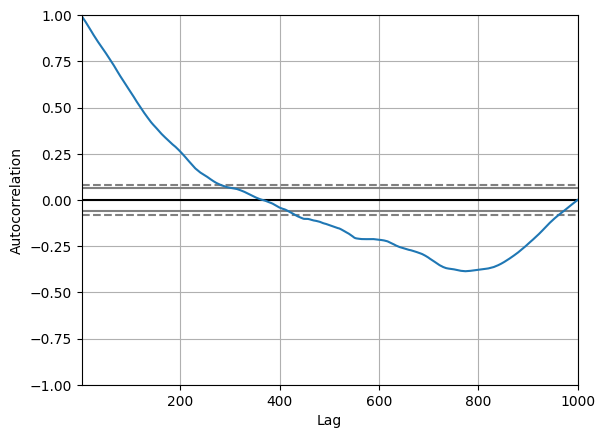

In [555]:
autocorrelation_plot(train['vwap']) #q= 1

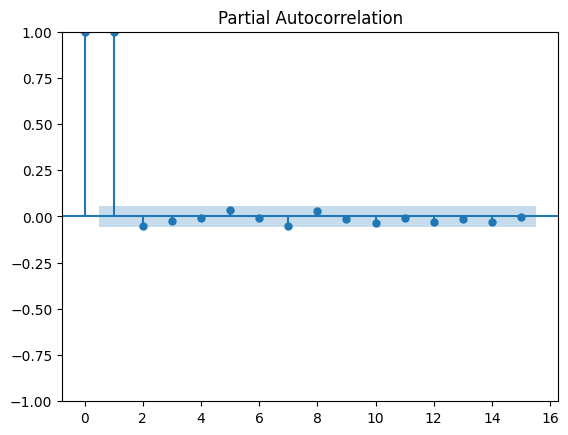

In [556]:
plot_pacf(df['vwap'], lags=15)
plt.show()  #p=2

In [557]:
arima_model = ARIMA(train['vwap'], exog=train[ind_features], order=(2, 1, 1)) # p,d,q
arima_model_fit = arima_model.fit()

In [558]:
# Forecast
arima_forecast = arima_model_fit.forecast(steps=len(test), exog=test[ind_features])

In [559]:
len(test)

179

In [560]:
np.array(arima_forecast)

array([ 794.35503507,  794.96298082,  800.69031588,  799.82351625,
        800.68817498,  799.71070104,  804.3652128 ,  808.04536374,
        811.41449073,  815.36559615,  819.87160302,  824.48034638,
        822.40819397,  820.48413487,  820.10920158,  823.67846144,
        823.32968611,  820.34617812,  818.5251224 ,  827.03087488,
        855.75419193,  873.13892024,  883.68987132,  889.61336922,
        911.56036022,  918.99581113,  927.15905646,  928.18776643,
        925.52955412,  921.7756412 ,  913.28320713,  910.38041198,
        911.39513807,  924.56989185,  933.76433064,  935.16474547,
        931.39194437,  928.4803232 ,  929.95322425,  933.1486663 ,
        947.7313395 ,  956.66747337,  957.2433109 ,  963.80438961,
        970.74736432,  978.96224583, 1016.30129447, 1022.26183882,
       1031.75421757, 1026.36686   , 1027.81105704, 1005.70289171,
        995.00261005,  978.19796843,  960.22434496,  959.46423766,
        952.22925408,  950.89407106,  952.34977081,  965.60901

In [561]:
# Add forecast to test set
test['arima_forecast'] = np.array(arima_forecast)

<Axes: xlabel='date'>

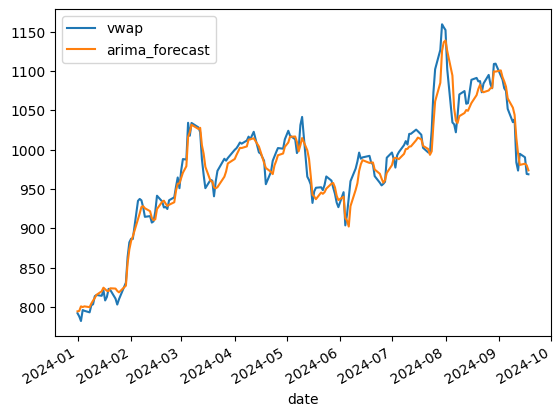

In [562]:
test[['vwap','arima_forecast']].plot()

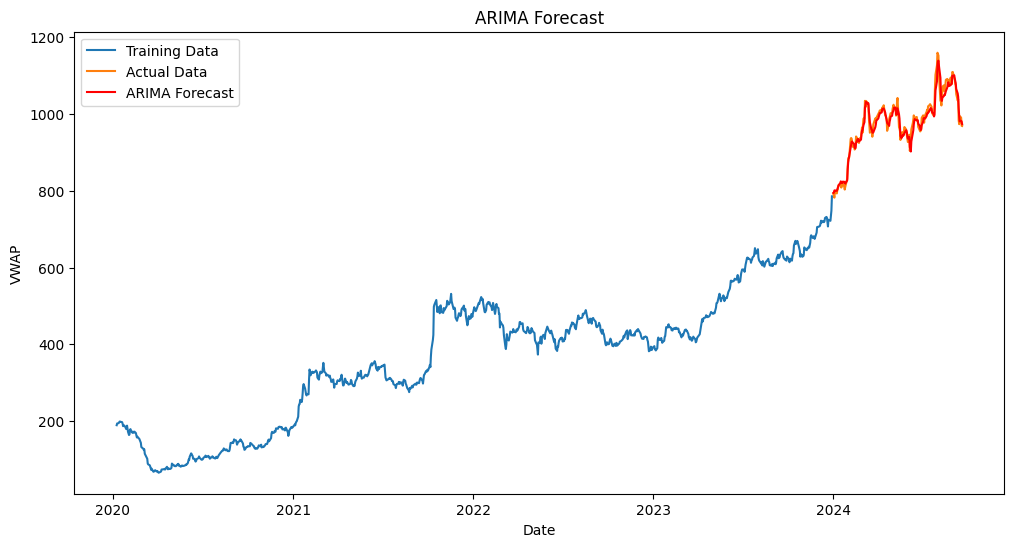

ARIMA Mean Squared Error: 222.2045479279019


In [563]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train['vwap'], label='Training Data')
plt.plot(test['vwap'], label='Actual Data')
plt.plot(test['arima_forecast'], label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('VWAP')
plt.legend()
plt.show()

# Evaluate model
mse_arima = mean_squared_error(test['vwap'], arima_forecast)
print(f'ARIMA Mean Squared Error: {mse_arima}')

# **Apply SARIMA Model**

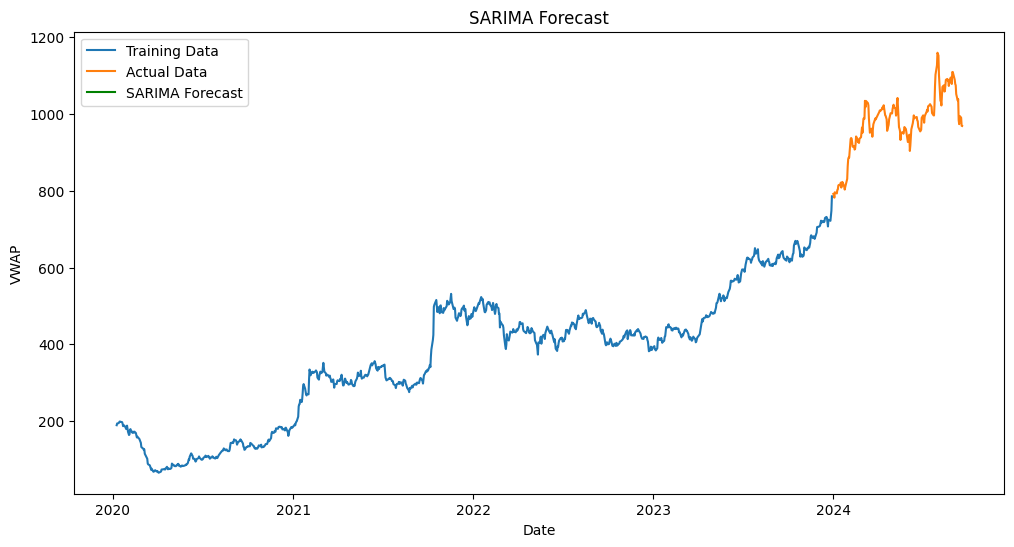

SARIMA Mean Squared Error: 3431.003167291114


In [564]:
# Fit SARIMA model
sarima_model = SARIMAX(train['vwap'], exog=train[ind_features], order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))  # Adjust orders as necessary
sarima_model_fit = sarima_model.fit()

# Forecast
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test['vwap']), exog=test[ind_features]).predicted_mean

# Add forecast to test set
test['sarima_forecast'] = sarima_forecast

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train['vwap'], label='Training Data')
plt.plot(test['vwap'], label='Actual Data')
plt.plot(test['sarima_forecast'], label='SARIMA Forecast', color='green')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('VWAP')
plt.legend()
plt.show()

# Evaluate model
mse_sarima = mean_squared_error(test['vwap'], sarima_forecast)
print(f'SARIMA Mean Squared Error: {mse_sarima}')


In [565]:
# Add forecast to test set
test['sarima_forecast'] = np.array(sarima_forecast)

In [566]:
test['sarima_forecast']

date
2024-01-01     789.166795
2024-01-02     793.377086
2024-01-03     800.506035
2024-01-04     798.737846
2024-01-05     797.539581
                 ...     
2024-09-12    1094.562009
2024-09-13    1089.786821
2024-09-16    1090.211922
2024-09-17    1090.210984
2024-09-18    1085.164057
Name: sarima_forecast, Length: 179, dtype: float64

<Axes: xlabel='date'>

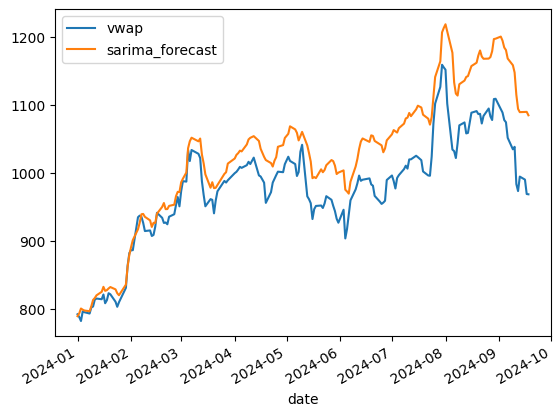

In [567]:
test[['vwap','sarima_forecast']].plot()

In [568]:
np.sqrt(mse_sarima)

58.57476561874673

In [569]:
58.57476561874673
62.36926960547461

62.36926960547461

In [570]:
np.sqrt(mse_arima)

14.906527024357548

In [571]:
14.906527024357548

14.906527024357548

# **ThankYou**